# Using Markov-Chain Monte Carlo (MCMC) approaches to fitting a function.

We will use MCMC to fit a power law to the distribution of HI density parameters with redshift: $\Omega_{\rm gas}^{\rm DLA}(z)$.


We will fit a functional form to the density parameter measurements from DLAs of the form:

$\Omega_{\rm gas}(z) = k\, (1+z)^\alpha$.

In [1]:
# Typical imports here
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c

from astropy.modeling import models, fitting
from astropy.table import Table,Column
import pickle

# Code to read in the data points to be fit

In [2]:
# %run pyfit_omega.py

In [3]:
def load_omegadata(inputfile='./Data/HI_density.asc'):
# def load_omegadata(inputfile='./HI_density_for_Celine_v181012.dat'):
    ### OMEGA_HI ###

    # colnames = 'id, z_HI, errm_z_HI, errp_z_HI, time, errm_time, errp_time, Omega_HI, errm_Omega_HI, errp_Omega_HI'.split(', ')
    colnames = 'id, z_HI, errm_z_HI, errp_z_HI, Omega_HI, errm_Omega_HI, errp_Omega_HI'.split(', ')
    omega = Table.read(inputfile,names=colnames,
            format='ascii',comment='#')

    # Values in table are in units of 1e-3, so correct this:
    omega['Omega_HI'] *= 1.e-3
    omega['errm_Omega_HI'] *= 1.e-3
    omega['errp_Omega_HI'] *= 1.e-3

    #Correct to Omega_gas by accounting for Helium:  mu=1.3
    mu = 1.3
    omega.add_column(Column(np.round(omega['Omega_HI']*mu,6),name='Omega_gas'))
    errormp_Omega_gas = [omega['errm_Omega_HI'].data*mu,
                            omega['errp_Omega_HI'].data*mu]
    error_Omega_gas = np.mean(errormp_Omega_gas,axis=0)
    omega.add_column(Column(np.transpose(error_Omega_gas),
                name='err_Omega_gas'))
    omega.add_column(Column(np.transpose(errormp_Omega_gas),
                name='errmp_Omega_gas'))


    errormp_z = [omega['errm_z_HI'].data, omega['errp_z_HI'].data]
    omega.add_column(Column(np.transpose(errormp_z),
                name='errmp_z_HI'),index=2)
    omega.remove_columns(['errm_z_HI','errp_z_HI',
                            'errm_Omega_HI','errp_Omega_HI'])
    return omega


# MCMC tutorial code

This is code that comes from the documentation from `emcee`.


In [4]:
import emcee
emcee.__version__

'3.0rc1'

In [5]:
def lnprob(x, mu, icov):
    diff = x-mu
    return -np.dot(diff,np.dot(icov,diff))/2.0

In [6]:
ndim = 5

means = np.random.rand(ndim)

cov = 0.5 - np.random.rand(ndim ** 2).reshape((ndim, ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov,cov)

icov = np.linalg.inv(cov)

In [7]:
nwalkers = 250
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

In [8]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[means, icov])

In [9]:
pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.reset()

In [10]:
samples=sampler.run_mcmc(pos, 1000)

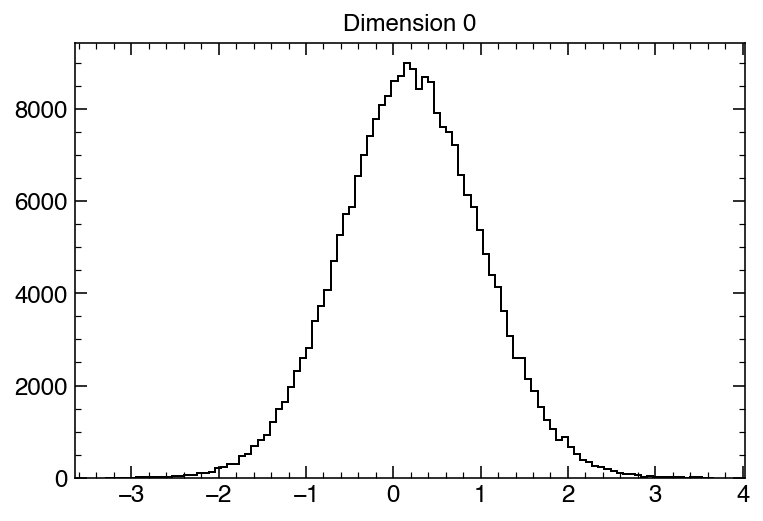

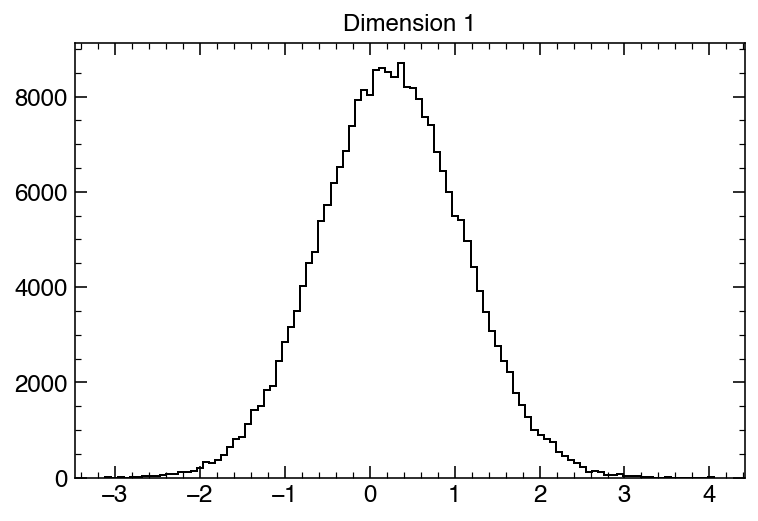

In [11]:
import matplotlib.pyplot as pl

for i in range(ndim-3):
    pl.figure()
    pl.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    pl.title("Dimension {0:d}".format(i))

## Load the HI data

In [12]:
powlaw_color = 'darkgreen'
powlaw_color = '#4EA649'
powlaw_line_color = 'darkgreen'

xlimits = [-0.12,5.6]
ylimits = [0,3.4e-3]
ylimits = [0,30]

In [13]:
omega = load_omegadata()
z = omega['z_HI'].data
zmin = z - omega['errmp_z_HI'].data[:,0]
zmax = z + omega['errmp_z_HI'].data[:,1]
y = omega['Omega_gas'].data*1.e4
yerr = omega['err_Omega_gas'].data*1.e4

# First: look at a Maximum likelihood fit to $\Omega_{\rm gas}$

This is done to initialize the location of the walkers in our MCMC run.

This follows the `emcee` [documentation / tutorials.](https://emcee.readthedocs.io/en/stable/tutorials/line/)

#### 1. We first have to define a likelihood function, in this case the log of the likelihood.

In [80]:
def log_likelihood(theta, zmin, zmax, y, yerr):
    k, alpha = theta
    sigma2 = yerr**2
    
    model = []
    for j in np.arange(np.size(zmin)):
        # Because each measurement covers a range in z, 
        # I create several data points within the range. 
        # This allows for variations in the model within the bin.        
        zzz = np.linspace(zmin[j],zmax[j],10)
        model.append(np.mean(k*(1.+zzz)**alpha))
    model=np.array(model)
    
    return -0.5*np.sum((y-model)**2/sigma2 + np.log(sigma2))

#### 2. Now we use `scipy.optimize.minimize` to minimize the negative log likelihood

In [123]:
from scipy.optimize import minimize
np.random.seed(42)

nll = lambda *args: -log_likelihood(*args)
initial = np.array([4.6, 0.58])*(1+0.2*np.random.randn(2))

soln = minimize(nll, initial, args=(zmin, zmax, y, yerr))
k_ml, alpha_ml = soln.x

print("Maximum likelihood estimates:")
print("k = {0:.3f}".format(k_ml))
print("alpha = {0:.3f}".format(alpha_ml))

Maximum likelihood estimates:
k = 4.552
alpha = 0.579


```

```
_This gives us an initial guess for initializing our MCMC walkers._

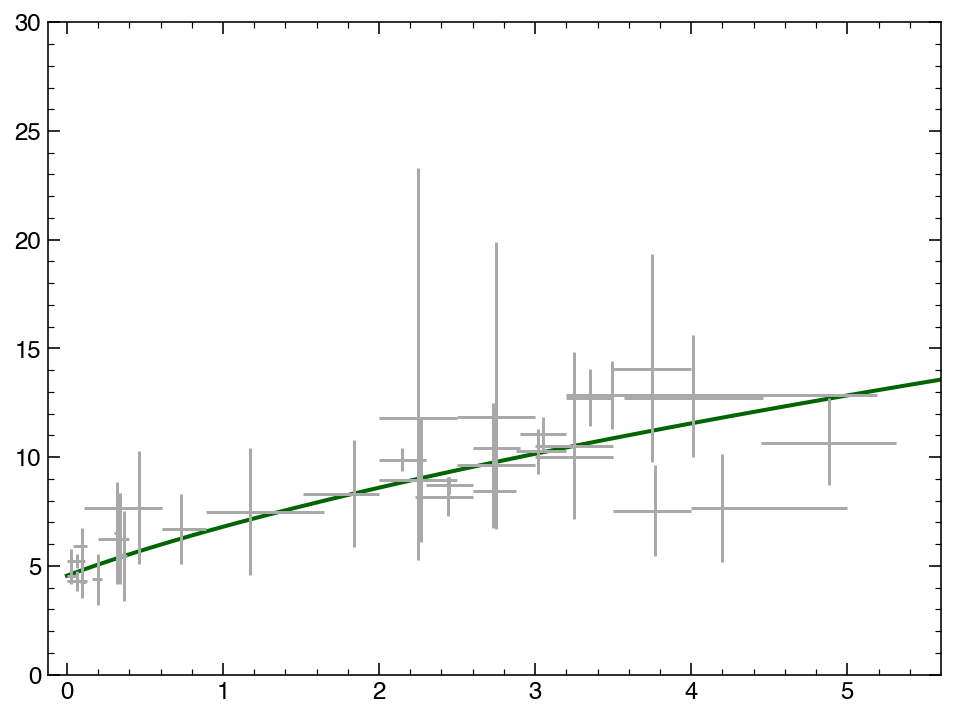

In [82]:
zgrid = np.arange(0,6,0.05)

plt.figure(figsize=(8,6))#width and heigth in inches
ax1=plt.subplot(111)

ax1.errorbar(omega['z_HI'], omega['Omega_gas']*1.e4,
            xerr=np.transpose(omega['errmp_z_HI']),
            yerr=np.transpose(omega['errmp_Omega_gas']*1.e4),
            linestyle='', zorder=3,
            elinewidth=1.5,ecolor='darkgrey',
            # elinewidth=1.5,ecolor=colors['DLAdata'],
            capsize=0,barsabove=False,
            color='w',label='')

ax1.plot(zgrid,k_ml*(1+zgrid)**alpha_ml,
            label='Power law fit',linewidth=2,
            color=powlaw_line_color)
ax1.set_xlim(xlimits)
ax1.set_ylim(ylimits);

# MCMC fit to $\Omega_{\rm gas}$

Now that we have an initial guess, let's use `emcee` to derive MCMC results.

### Define the likelihood, priors

Our MCMC modeling requires two probabilities:

1. The likelihood function, telling us about the comparison with the data.
2. Bayesian priors, telling us about "prior information."

In [83]:
def log_likelihood(theta, zmin, zmax, y, yerr):
    k, alpha = theta
    sigma2 = yerr**2
    
    model = []
    for j in np.arange(np.size(zmin)):
        zzz = np.linspace(zmin[j],zmax[j],10)
        model.append(np.mean(k*(1.+zzz)**alpha))
    model=np.array(model)
    
    return -0.5*np.sum((y-model)**2/sigma2 + np.log(sigma2))

Our default priors for the two parameters, ($k, \ \alpha$), are just flat over a pretty broad range:

In [84]:
def log_prior(theta):
    k, alpha = theta

    if 0. < k < 15. and -1. < alpha < 1.5:
        return 0.0
    return -np.inf

The joint probability is the sum of the logarithmic priors and likelihood functions.

In [85]:
def log_probability(theta, zmin, zmax, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, zmin, zmax, y, yerr)

#### Run the MCMC sampling

Now we initialize our walkers placed randomly about our initial parameters. In our case we use 32 walkers.

In [96]:
pos = soln.x + 1e-4*np.random.randn(32, 2)
nwalkers, ndim = pos.shape

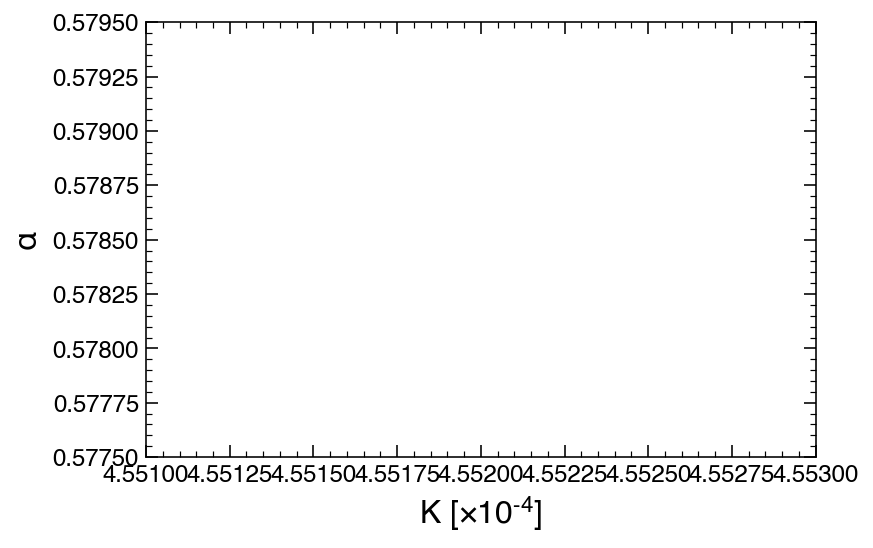

In [122]:
plt.plot(pos[:,0],pos[:,1],'o',alpha=0.5,color=powlaw_color)
plt.xlim(4.551,4.553)
plt.ylim(0.5775,0.5795)
plt.ylabel('$\\alpha$',fontsize=16);
plt.xlabel('$K \ [\\times10^{-4}]$',fontsize=16);

Now we use `emcee` to sample the parameter space, letting the walkers find their way into the most likely regions. 

Here we use 2000 steps.

This can take awhile...

In [104]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(zmin, zmax, y, yerr))
sampler.run_mcmc(pos, 2000, progress=True);

100%|██████████| 2000/2000 [04:34<00:00,  7.29it/s]


### Plot walker values at each step

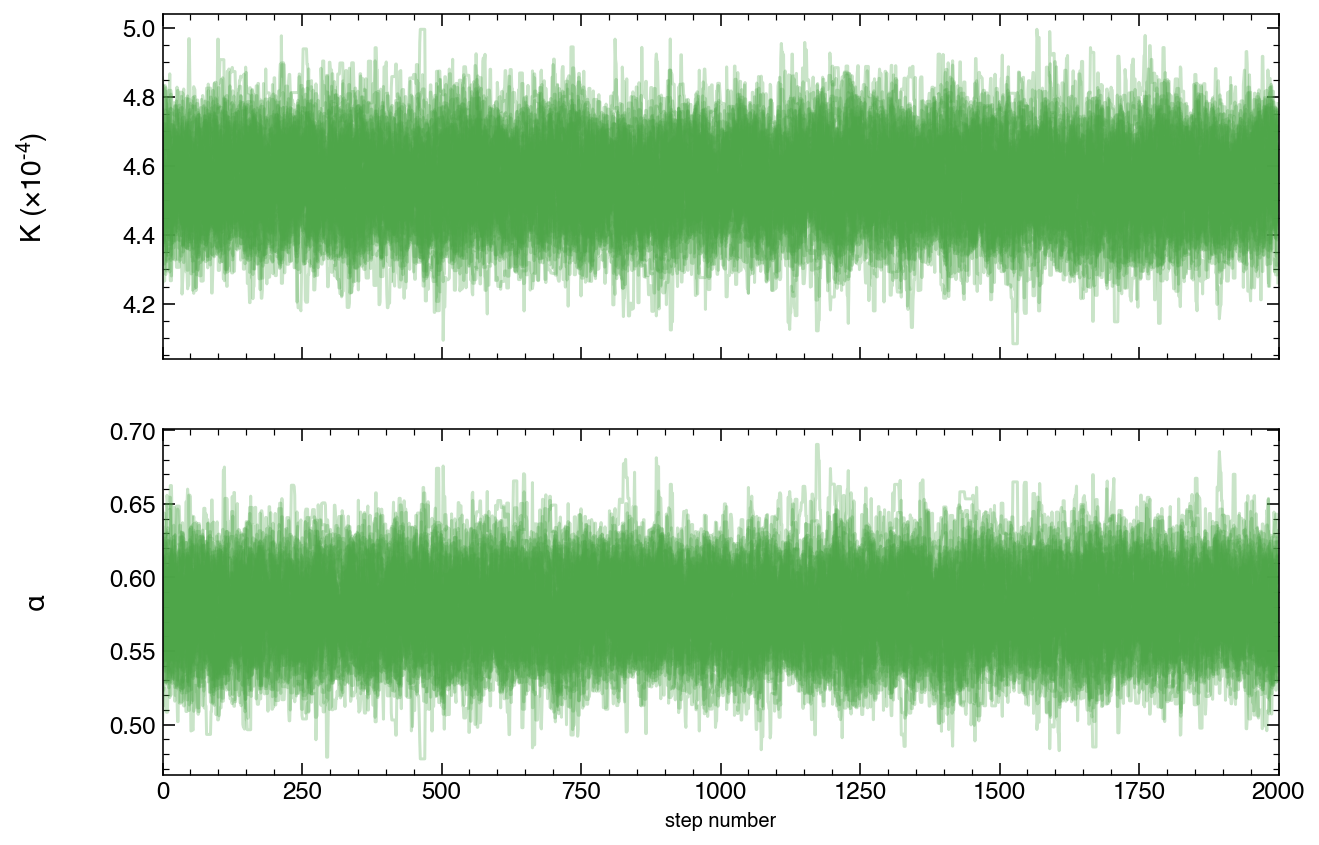

In [106]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$K\ (\\times10^{{{-4}}})$", "$\\alpha$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], color=powlaw_color, alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],fontsize=14)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

### Test the convergence

One wants the total chain length to be >50 times the autocorrelation time. This procedure will throw an error if this criterion is not met.

In [107]:
tau = sampler.get_autocorr_time()
print(tau)

[26.47914526 29.19019241]


In [108]:
flat_samples = sampler.get_chain(discard=100, flat=True)
print(flat_samples.shape)

(121600, 2)


# Summarizing the output parameters

In [109]:
from IPython.display import display, Math


i=0
mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
q = np.diff(mcmc)
txt = "\mathrm{{{3}}} = ({0:.3f}_{{-{1:.3f}}}^{{{2:+.3f}}}) \\times 10^{{-4}}"
txt = txt.format(mcmc[1], q[0], q[1], 'K')
display(Math(txt))
kmcmc = mcmc
kq = q

i=1
mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
q = np.diff(mcmc)
txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:+.4f}}}"
txt = txt.format(mcmc[1], q[0], q[1], '\\alpha')
display(Math(txt))
amcmc = mcmc
aq = q


<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Plotting the results

## Corner plot

Many summaries of MCMC data use the `corner` package.

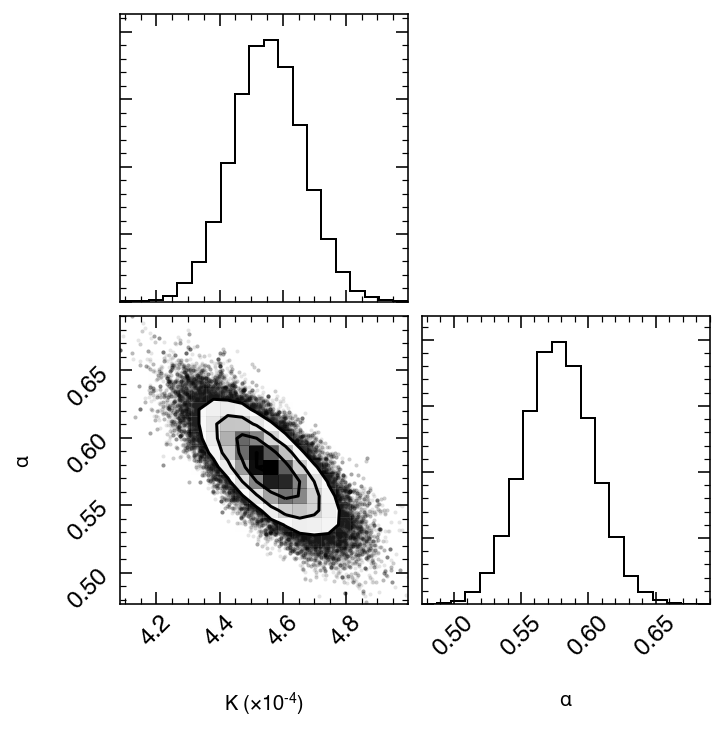

In [110]:
import corner
# fig = corner.corner(flat_samples, labels=labels, truths=[4.6e-4,0.58]);
fig = corner.corner(flat_samples, labels=labels)

## pygtc plots

I prefer the visual style of `pygtc`.

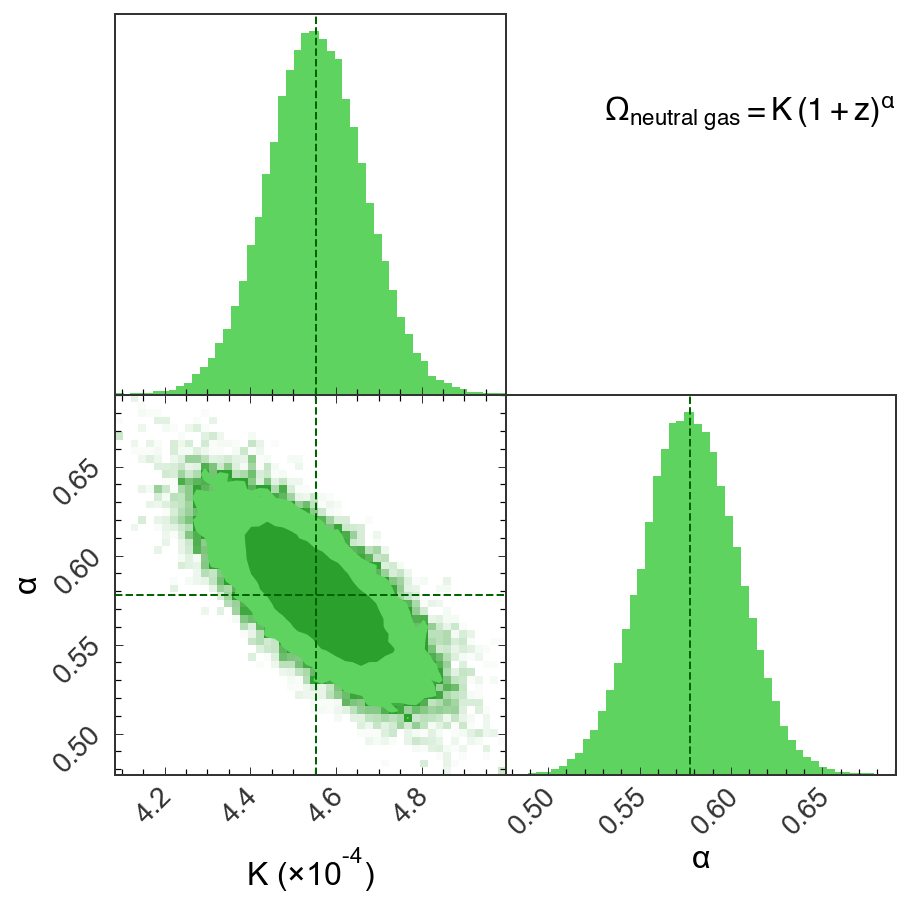

In [118]:
import pygtc
cfig = pygtc.plotGTC(flat_samples, paramNames=labels, colorsOrder=['greens'],
                    truths=[kmcmc[1],amcmc[1]],truthColors=[powlaw_line_color],
                    plotDensity=True, 
                     figureSize = 7, mathTextFontSet=None,
                     filledPlots=True, 
                     nBins=50, smoothingKernel=0.,
                     customTickFont={'family':'Arial', 'size':14},
                     customLabelFont={'family':'Arial', 'size':16}
                    )
powlaw_text = "$\Omega_{{neutral\ gas}} = K\, (1+z)^\\alpha$"

cfig.text(0.9,0.8,powlaw_text,
         va='top',ha='right',fontsize=16);

# Plot the power law fits with the data

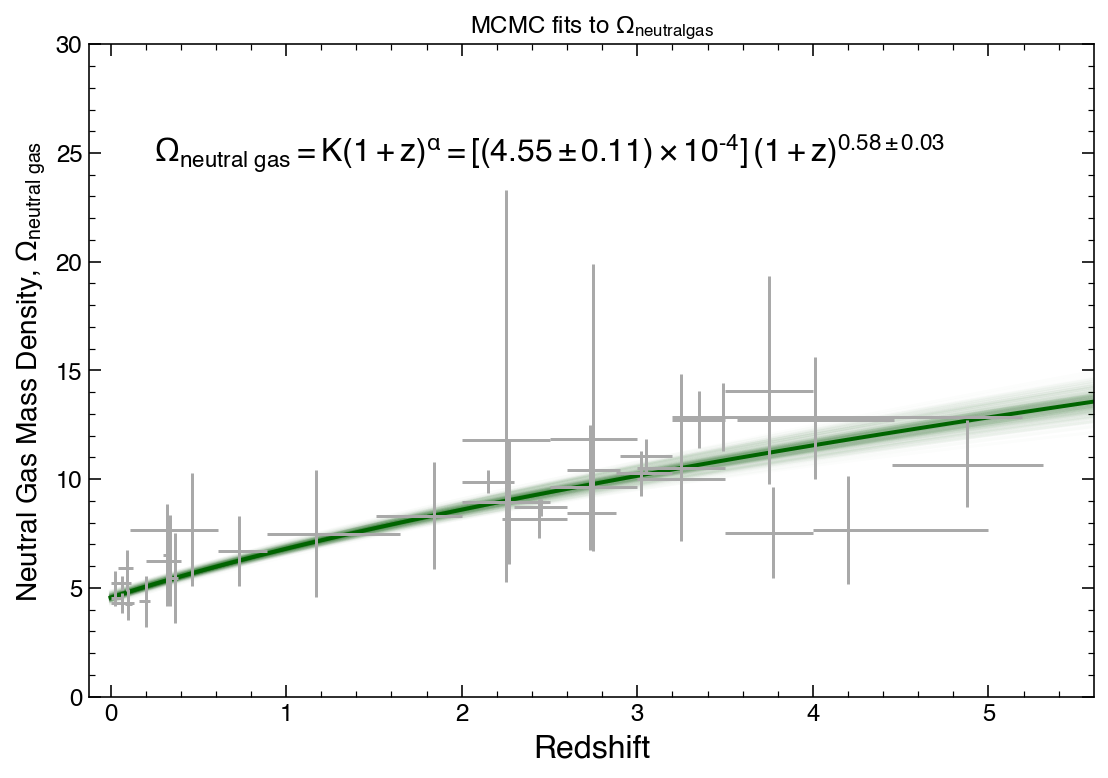

In [121]:
zgrid = np.arange(0,6,0.05)

plt.figure(figsize=(9,6))#width and heigth in inches
ax1=plt.subplot(111)

inds = np.random.randint(len(flat_samples), size=250)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(zgrid, sample[0]*(1+zgrid)**sample[1], powlaw_line_color, alpha=0.01)
    
ax1.errorbar(omega['z_HI'], omega['Omega_gas']*1.e4,
            xerr=np.transpose(omega['errmp_z_HI']),
            yerr=np.transpose(omega['errmp_Omega_gas']*1.e4),
            linestyle='', zorder=3,
            elinewidth=1.5,ecolor='darkgrey',
            # elinewidth=1.5,ecolor=colors['DLAdata'],
            capsize=0,barsabove=False,
            color='w',label='')

ax1.plot(zgrid,k_ml*(1+zgrid)**alpha_ml,
            label='Power law fit',linewidth=2,
            color=powlaw_line_color)
ax1.set_xlabel(r"Redshift",fontsize=16)
ax1.set_ylabel("Neutral Gas Mass Density, $\Omega_{neutral\ gas}$",fontsize=14)

powlaw_text = "$\Omega_{{neutral\ gas}} = K (1+z)^\\alpha = [({0:0.2f} \pm {1:0.2f}) \\times 10^{{-4}} ] \, (1+z)^{{{2:0.2f} \pm {3:0.2f}}}$".format(\
            kmcmc[1],np.mean([kq[0],kq[1]]),
            amcmc[1],np.mean([aq[0],aq[1]]))
ax1.text(0.25,25,powlaw_text,
         va='center',ha='left',fontsize=16)
ax1.set_title('MCMC fits to $\\Omega_{neutral gas}$')
ax1.set_xlim(xlimits)
ax1.set_ylim(ylimits);